# Load .csv files and format the events to save them as .npy files and load them easily

In [ ]:
import glob, ast
import pandas as pd
from tqdm import tqdm
import numpy as np

# path specific to your machine
path = '/Users/joe/Nextcloud/APROVIS3D-data/2021-12-06_simulator_data/'
%cd $path
list_csv = glob.glob('*.csv')
list_npy = glob.glob('*.npy')
print(f'list of all .csv files : \n {list_csv}')

index = 'xytp'

#because at some point I have the end of the .csv file that is composed of NaNs.
#this line is just to prevent from stopping the script at the end of a damaged file
#can be commented if files are not corrupted
event_limit = [5573, 19387, 42340, 941, 41480, 100000, 100000]

for number, name in enumerate(list_csv):
    if name[:-4]+'.npy' not in list_npy:
        print(f'loading: {name}')
        df = pd.read_csv(path+name)
        events = None
        index = 0
        for index, row in tqdm(df.iterrows(), total=df.shape[0]):
            # can be commented if files are not corrupted
            if index<event_limit[number]:
                text = row['.events']
                text = text.replace('[', '[{').replace(']', '}]').replace('\n', ', ').replace(' ts: ,', '').replace(", x", "}, {x").replace("x", "'x'").replace(" y", " 'y'").replace(" secs", " 'secs'").replace(" nsecs", " 'nsecs'").replace(" polarity", " 'polarity'")
                mydict = ast.literal_eval(text)
                x = pd.DataFrame.from_dict(mydict)['x'].values
                y = pd.DataFrame.from_dict(mydict)['y'].values
                t = pd.DataFrame.from_dict(mydict)['secs'].values*1e6+pd.DataFrame.from_dict(mydict)['nsecs'].values*1e-3
                p = pd.DataFrame.from_dict(mydict)['polarity'].values
                if events is not None:
                    events = np.vstack((events, np.array([x,y,t,p]).T))
                else:
                    events = np.array([x,y,t,p]).T
        np.save(path+name[:-4], events)
    else: print(f'{name} was already loaded saved as .npy file')

# Open the .npy files and get some information

In [20]:
#print(f'list of all .npy files : \n {list_npy}')
D = []
for name in list_npy:
    events = np.load(path+name)
    duration = (events[-1,2]-events[0,2])*1e-6
    nb_events = events.shape[0]
    nb_OFF = (events[:,3]==0).sum()
    nb_ON = (events[:,3]==1).sum()
    density = nb_events/duration
    D.append(density*1e-3)
    print(f'file name: {name}')
    print(f'recording duration: {np.round(duration)} s \n events density: {np.round(density,3)} ev/sec \n number of ON/OFF events: {np.round(nb_ON/nb_OFF,3)}\n')

file name: mixed_session_2.npy
recording duration: 323.0 s 
 events density: 7418.496 ev/sec 
 number of ON/OFF events: 0.953

file name: mixed_session_3.npy
recording duration: 705.0 s 
 events density: 13822.538 ev/sec 
 number of ON/OFF events: 0.897

file name: mixed_session_1.npy
recording duration: 93.0 s 
 events density: 8614.034 ev/sec 
 number of ON/OFF events: 1.013

file name: only_sea_session_3.npy
recording duration: 691.0 s 
 events density: 13764.88 ev/sec 
 number of ON/OFF events: 0.999

file name: only_sea_session_2.npy
recording duration: 1328.0 s 
 events density: 10873.698 ev/sec 
 number of ON/OFF events: 0.999

file name: only_sea_session_1.npy
recording duration: 16.0 s 
 events density: 5954.397 ev/sec 
 number of ON/OFF events: 0.779

file name: only_ground_session_1.npy
recording duration: 636.0 s 
 events density: 39175.777 ev/sec 
 number of ON/OFF events: 1.003



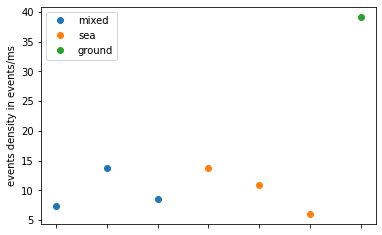

In [36]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(np.arange(3),D[:3], 'o', label = 'mixed')
ax.plot(np.arange(3,6), D[3:6], 'o', label = 'sea')
ax.plot([6], D[6:], 'o', label = 'ground')
ax.set_ylabel('events density in events/ms');
ax.set_xticklabels([]);
plt.legend()

In [37]:
fig.savefig('event_density.pdf')